# Source

https://www.kaggle.com/code/infocusp/diffstride-explainable-notebook

# Overview

Mendeskripsikan intisari suatu ide dari artikel ilmiah ["Learning strides in convolutional neural network"](https://arxiv.org/pdf/2202.01653.pdf) bersamaan dengan beberapa ide latar belakang dan visualisasinya.
artikel ilmiah tersebut adalah salah satu dari banyak artikel ilmiah yang menerima penghargaan ["outstanding paper awards"](https://blog.iclr.cc/2022/04/20/announcing-the-iclr-2022-outstanding-paper-award-recipients/) pada event ICLR 2022

Dengan asumsi pembaca sudah mengenal dasar dari arsitektur CNN. Jika pembaca masih belum mengetahui mengenai dasar dari arsitektur CNN, maka dapat mempelajari melalui [materi berikut](https://cs231n.github.io/) pada event ICLR 2022

# Penjelasan singkat mengenai artikel ilmiah

- Arsitektur pada Model CNN umumnya memiliki beberapa tahapan downsampling yang secara progresif mengurangi resolusi dari representasi perantara dimana prosesnya akan dilanjutkan lebih dalam ke jaringan (network)
- Tujuan dari downsampling adalah memberikan beberapa pergeseran invarian dan mengurangi jumlah komputasi yang diperlukan oleh arsitektur dan disisi lain juga mempertahankan informasi penting dari dataset original citra
- Salah satu hyperparameter dari lapisan Convolution pada CNN yang mengontrol jumlah downsampling adalah stride. Stride pada dasarnya adalah suatu langkah ukuran (dalam arah horizontal dan vertikal) yang diterapkan di lapisan Convolution saat memutar (convolving) suatu citra
- Sebagai contoh: stride = 1 memindahkan filter sejumlah 1 langkah dalam satu waktu saat pemutaran, stride = 2 memindahkan filter sejumlah 2 langkah dalam satu waktu saat pemutaran
- Dikarenakan ukuran stride tidak dapat dibedakan (not differentiable), mencari konfigurasi terbaik dari suatu stride untuk layer yang berbeda membutuhkan proses _crossvalidation_ atau _discrete optimization_. Sebagai contoh pada studi kasus untuk menemukan aristektur terbaik, dengan cara mencoba berbagai macam nilai dan memilih salah satu dari berbagai nilai tersebut yang memberikan hasil yang terbaik, dimana akan menghabiskan lebih banyak waktu dalam proses training.

Interpretasi visual dari strides


![Strides_0](/asset/strides_0.jpg)

![Strides_1](/asset/strides_1.jpg)

![Strides_2](/asset/strides_2.jpg)

[Ref: Apa yang dimaksud dengan "stride" pada Convolutional Neural Network](https://medium.com/machine-learning-algorithms/what-is-stride-in-convolutional-neural-network-e3b4ae9baedb)

Langkah serupa pada perhitungan strides juga berlaku saat melakukan operasi pooling (pooling operation)

Apakah ada cara lain untuk menentukan suatu stride yang optimal menggunakan algoritma
optimisasi seperti _gradient descent_ (sehingga memungkinkan untuk melakukan optimisasi dengan biaya komputasi yang lebih rendah)

- Jawaban dari pertanyaan tersebut adalah menggunakan Metode Diffstride. Merupakan metode yang mengenalkan teknik downsampling dengan stride yang langkah yang dapat dipelajari (learnable strides). Sebuah lapisan yang dapat dipelajari (learnable layer) yang menentukan ukuran dari _cropping mask_ (yang diimplementasikan pada representasi domain _fourier_), sehingga dapat mengubah ukuran dengan cara yang dapat dibedakan (differentiable). Cara kerja dari diffstride secara detail akan dijabarkan lebih lanjut. Namun terlebih dahulu ditampilkan hasil atau outcome dalam penggunaan diffstride terlebih dahulu.
- Artikel ilmiah ini mendemonstrasikan efektivitas dari penggunaan DiffStride (beserta kemampuannya secara general) terhadap kasus klasifikasi citra. Hasil yang dijabarkan dari artikel ilmiah tersebut ditampilkan pada tabel dibawah. Berdasarkan pada tabel dibawah menunjukkan bahwa penerapan DiffStride pada Model Arsitektur ResNet18 mengungguli semua Teknik Downsampling dalam penerapannya pada Model Arsitektur ResNet18 standar.

| Init. Strides | Strided Conv. | Spectral   | DiffStride | Strided Conv. | Spectral   | DiffStride |
| ------------- | ------------- | ---------- | ---------- | ------------- | ---------- | ---------- |
| (2, 2, 2)     | 91.4 ± 0.2    | 92.4 ± 0.1 | 92.5 ± 0.1 | 66.8 ± 0.2    | 73.7 ± 0.1 | 73.4 ± 0.5 |
| (2, 2, 3)     | 90.5 ± 0.1    | 92.2 ± 0.2 | 92.8 ± 0.1 | 63.4 ± 0.5    | 73.7 ± 0.2 | 73.5 ± 0.0 |
| (1, 3, 1)     | 90.0 ± 0.4    | 91.1 ± 0.1 | 92.4 ± 0.1 | 64.9 ± 0.5    | 70.3 ± 0.3 | 73.4 ± 0.2 |
| (3, 1, 3)     | 85.7 ± 0.1    | 90.9 ± 0.2 | 92.4 ± 0.1 | 55.3 ± 0.8    | 69.4 ± 0.4 | 73.7 ± 0.4 |
| (3, 1, 2)     | 86.4 ± 0.1    | 90.9 ± 0.2 | 92.3 ± 0.1 | 56.2 ± 0.3    | 69.9 ± 0.2 | 73.4 ± 0.3 |
| (3, 2, 3)     | 82.0 ± 0.6    | 89.2 ± 0.2 | 92.3 ± 0.1 | 48.2 ± 0.2    | 66.6 ± 0.5 | 73.6 ± 0.4 |
| **Mean Acc:** | 87.7 ± 3.4    | 91.1 ± 1.1 | 92.4 ± 0.2 | 59.1 ± 6.7    | 70.6 ± 2.6 | 73.5 ± 0.3 |

# Beberapa Persyaratan

Untuk memahami intisari suatu ide dibalik diffstride, penting bagi pembaca untuk memahami konsep berikut:

- FFT - _Fourier Domain Representation of Image_
- Dualitas antara _convolution_ dalam domain citra dan perkalian elemen dalam _domain fouriers_

Jika sudah familiar terhadap konsep tersebut, maka bagian ini dapat di skip.

# Fourier Transform

Teorema Fourier menyatakan bahwa: setiap fungsi kontinu (continous function) dapat direpresentasikan sebagai penjumlahan berbobot tak terbatas (infinte weighted summation) dari gelombang sinus dan cosinus dengan frekuensi yang berbeda. Bobot (weight coefficients) dari gelombang sinus dan cosinus ini merupakan representasi domain frekuensi dari sinyal yang diberikan.

Cermati kasus sinyal 1D dibawah ini.

Sebagai contoh, diketahui gelombang sinus dari 2 frekuensi konstituen, membentuk sinyal yang diberikan. Kemudian pada domain waktu, sinyal campuran (mixed signal) akan direpresentasikan sebagai penambahan amplitudo dua sinyal sinusodial.

Kemudian kita mengimplementasikan DFT pada sinyal campuran (mixed signal). Sehingga sebagai representasi _fourier domain_, kita akan memperoleh puncak dari frekuensi konstituen yang merepresentasikan amplitudonya dalam domain waktu.

![Discrete Fourier Transform](/asset/fourier_transform.bmp)

[Ref: Issac's science blog](https://isaacscienceblog.com/2017/08/13/fourier-transform/)

# Discrete Fourier Transform (DFT) of images

Sinyal dalam kehidupan nyata bersifat kontinu (continous) dalam periode waktu tertentu. Apa yang kita amati merupakan rangkaian variasi cahaya.

Namun, saat mengkonversinya menjadi bentuk citra, ditangkap versi diskrit yang sama. Sehingga citra apa pun akan direpresentasikan sebagai array MxN dari nilai bilangan bulat.

Mengkonversi sinyal diskrit seperti ini ke domain fourier memerlukan _Discrete Time Fourier Transform (DTFT)_. Namun, output dari DTFT adalah fungsi kontinu periodik dalam domain _fourier_. Sehingga untuk melakukan komputasi/merepresentasikan dalam bentuk digital, kita mengambil sampel dari representasi berkelanjutan ini. Dimana disebut sebagai _Discrete Fourier Transform (DFT)_.

Sinyal _Discrete_ yang bersifat non periodik dapat didekati/diwakili (approximated/represented) dalam domain _fourier_ menggunakan koefisien DFT. Pada DFT apa yang akan kita lakukan sebenarnya adalah mencari _Discrete Time Fourier Transform Approximation_ pada interval dimana fungsi yang digunakan bersifat periodik.

_Fast Fourier Transform_ adalah cara/algoritma paralel yang efisien secara komputasi untuk menghitung DFT. FFT (_Fast Fourier Transform_) merupakan inti dari kompresi citra/audio/sinyal. Merupakan salah satu algoritma yang powerful dimasa saat ini. FFT merupakan cara untuk menghitung DFT.

Fourier Transform digunakan untuk menganalisis karakteristik frekuensi dari berbagai macam filter. Untuk citra, 2D _Discrete Fourier Transform (DFT)_ digunakan untuk mencari domain frekuensi. Detail terkait dengan hal tersebut dapat ditemukan pada buku yang membahas mengenai _image processing_ atau _signal processing_. Mari kita amati dengan menjalankan percobaan berikut

In [20]:
# Making necessary imports

import cv2
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Tuple, Optional, Type, Sequence, Union
import functools
import os
from absl import logging

Number = Union[float, int]
Stride = Union[Number, Tuple[Number, Number]]

!wget -c https://media.geeksforgeeks.org/wp-content/uploads/20200502194121/cameraman1.png

--2023-04-11 13:07:21--  https://media.geeksforgeeks.org/wp-content/uploads/20200502194121/cameraman1.png
Resolving media.geeksforgeeks.org (media.geeksforgeeks.org)... 18.155.68.39, 18.155.68.109, 18.155.68.8, ...
Connecting to media.geeksforgeeks.org (media.geeksforgeeks.org)|18.155.68.39|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



# Visualizing FFT

Pertama kita melakukan perhitungan DFT pada suatu citra menggunakan Algoritma FFT (keluar dari kotak opencv). DFT merupakan komponen nyata dan *imaginary* (yang direpresentasikan oleh 2 channels). Kita akan mengkomputasikan magnitude menggunakan komponen tersebut dan memplot spektrum yang dihasilkan.

In [21]:
# Visualizing FFT

img = cv2.imread('./cameraman1.png',0)
dft = cv2.dft(np.float32(img), flags = cv2.DFT_COMPLEX_OUTPUT)

# Ini merupakan praktek yang biasa digunakan 
# untuk menggeser komponen frekuensi dari rendah ke tengah
# Hal ini berguna untuk menampilkan visualisasi yang baik
# karena komponen frekuensi rendah akan muncul disekitar pusat
dft_shift = np.fft.fftshift(dft)

dft.shape

(256, 256, 2)

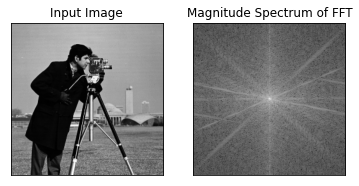

In [22]:
# Visualizing FFT

magnitude_spectrum = np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum of FFT'), plt.xticks([]), plt.yticks([])
plt.show()

# Spectral Pooling
Inti dari FFT adalah sebagian besar konten gambar terkandung dalam bagian frekuensi rendah. Komponen frekuensi tinggi mewakili tepi dan variasi pada citra. Sehingga saat diterapkan *low pass filtering* pada suatu citra, kita mempertahankan sebagian besar informasi tetap utuh bahkan saat membuang sebagian besar konten frekuensi tinggi dan mengurangi dimensi dalam jumlah besar. Ini adalah ide dari *spectral pooling* dan digunakan dalam kompresi menggunakan langkah-langkah berikut.

- Mengkonversi citra ke domain fourier menggunakan FFT
- Mengekstrasi frekuensi rendah (terkompresi) kecil dari representasi fourier
- Melakukan inverse FFT kembali ke domain citra (spasial).

Tidak seperti spatial pooling yang membutuhkan stride dengan tipe data integer, spectral pooling hanya membutuhkan dimensi output integer. 

# Compression process using FFT

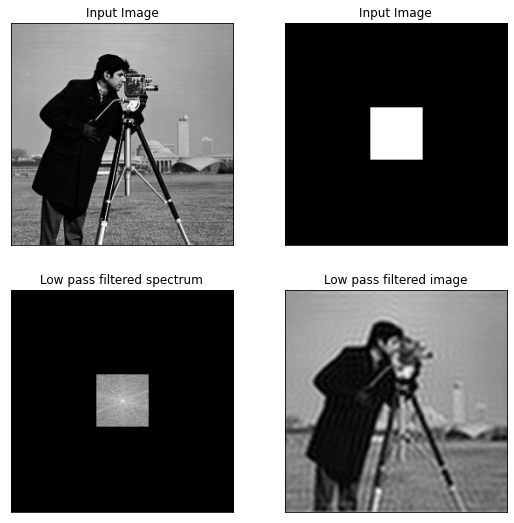

In [23]:
rows, cols = img.shape
crow, ccol = rows//2, cols//2

# Membuat mask, dengan center square 1, dan sisa semuanya 0
mask = np.zeros((rows, cols, 1), np.uint8)

# Center square dari ukuran center_filter_size disimpan dalam 1 (white) sisanya 0 
# Mencoba untuk wiggling center_filter_size untuk melihat tampilan idft
center_filter_size = 30 #@param {type:"integer"}
mask[crow-center_filter_size:crow+center_filter_size, ccol-center_filter_size:ccol+center_filter_size] = 1

# Implementasi mask
fshift = dft_shift * mask

# Geser kembali frekuensi ke lokasi semula dan jalankan inverse DFT
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.figure(figsize=[9,9])
plt.subplot(221),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([]);

plt.subplot(222),plt.imshow(mask[:,:,0], cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([]);

plt.subplot(223),plt.imshow(np.log(cv2.magnitude(fshift[:,:,0], fshift[:,:,1])+1), cmap = 'gray')
plt.title('Low pass filtered spectrum'), plt.xticks([]), plt.yticks([]);

plt.subplot(224),plt.imshow(img_back, cmap = 'gray')
plt.title('Low pass filtered image'), plt.xticks([]), plt.yticks([]);

Berdasarkan hasil observasi, hal yang menarik dari IDFT (*magnitude spectrum/low-pass-filter*) pada citra, adalah bahwa meskipun menggunakan dimensi kecil dari suatu data (60 out 256), kebanyakan informasi masih dapat diperoleh.

# Diffstride sebagai spectral pooling tetapi dengan not fixed window size

Berdasarkan pada pooling diatas, ukuran downsampling telah diperbaiki. Untuk mengatasi kasus parameter dari *searching stride*, diffstride memungkinkan spectral pooling untuk mempelajari stride melalui backpropagation.

Diffstride melakukan pemotongan dalam domain *Fourier* mirip dengan pengumpulan spektral. Namun, alih-alih menggunakan *fixed bounding box*, Diffstride mempelajari ukuran kotak (*box size*) melalui *backpropagation*. Box B yang dapat dipelajari di parameterkan oleh bentuk input, smoothness factor R dan strides, W akan dipelajari alih-alih diperbaiki.

Filter biasanya memiliki *short transition band*  ketika besarnya berkurang dengan halus dari 1 (passband: frequencies yang dapat melewati) ke 0 (stopband: tidak ada frekuensi yang melewati). Ini di refleksikan sebagai soft mask pada fungsi masking yang diterapkan. Ini adalah parameter desain filter klasik. R adalah *ramp softness*.

Alurnya ditunjukkan pada flowchart berikut.

![flowchart](/asset/flowchart.jpg)

Dengan pemahaman tersebut, mari kita dalami dengan melakukan implementasi dari berbagai lapisan pooling (downsampling).

# Spatial Pooling

Ini sama dengan pooling layer biasa (max pool/average pooling) dengan strides yang bersifat fixed upfront

In [24]:
# Spatial pooling

class SpatialPooling(tf.keras.layers.AveragePooling2D):
    """
    Fixed pooling layer, computed in the spatial domain
    """

    def __init__(self, 
                poolsize: Union[int, Tuple[int, int]] = (1, 1),
                strides: Stride = (2, 2),
                **kwargs):
        super().__init__(
            pool_size=pool_size, 
            strides=strides,
            padding='same',
            **kwargs
        )

# Fixed Spectral Pooling

- Bayangkan tensor sebagai kubus rubik, (dengan ukuran: 4x4x4). Pertimbangkan 10 kubus tersebut, maka ukuran batch = 10 dan CxHxW = 4x4x4
- Sehingga apa yang dilakukan fungsi di bawah ini (dengan pertimbangan, lower_height=2,upper_height=3,upper_width=3):
    - Untuk semua kubus (untuk semua poin pada batch), *stack 2 components on top of each other*:
        - **Component 1**: Untuk seluruh kedalaman kubus, ambil baris ke 0 dan ke 1 (sampai ketinggian yang lebih rendah = 2 tidak termasuk) dan kolom ke 0, ke 1 dan ke 2 (upper_width 3 tidak termasuk) Wilayah putih diarsir pada gambar di bawah ini.
        - **Component 2**: Untuk seluruh kedalaman kubus yang sama, ambil baris dari ketinggian atas hingga baris paling atas untuk kolom yang sama seperti sebelumnya. Wilayah merah pada gambar di bawah.

Perlu diingat, walaupun setelah menumpuk komponen 1 dan 2 kubus di atas satu sama lain, berbagai kubus berbaris dengancara yang sama seperti sebelumnya (satu di depan yang lain).



In [25]:
class FixedSpectralPooling(tf.keras.layers.Layer):
  """Fixed Spectral pooling layer, computed in the Fourier domain."""

  def __init__(self,
               strides: Stride = (2.0, 2.0),
               data_format: str = 'channels_first',
               **kwargs):
    """Fixed Spectral pooling layer.
    Args:
      strides: Fractional strides to apply via the Fourier domain.
      data_format: either 'channels_first' or 'channels_last'. Be aware that
        providing the data in channels_last format will significantly increase
        the overhead due to the need to transpose temporarily to channels_first.
      **kwargs: Additional arguments for parent class.
    """
    super().__init__(**kwargs)
    self._channels_first = data_format == 'channels_first'
    # Check if a single value (int or float) is given instead of a tuple. If so then convert the scalar to tuple.
    strides = (
        (strides, strides) if isinstance(strides, (int, float)) else strides)
    # Converting the elements of strides tuple to float values if scalar integer or tuple of integer was supplied  
    strides = tuple(map(float, strides))
    self._strides = strides
    # Restricting stride values to be greater than 1. 
    if not strides[0] >= 1 and strides[1] >= 1:
      raise ValueError('Strides params need to be above 1, not ({}, {})'.format(
          str(strides[0]), str(strides[1])))

  def build(self, input_shape):
    # First we ensure the input is in channels first format. 
    if self._channels_first:
      height, width = input_shape[2], input_shape[3]
    else:
      height, width = input_shape[1], input_shape[2]
    
    # Initialising weights of the layer as constants with our stride values
    self.strides = self.add_weight(
        shape=(2,), # A list with 2 values/scalars
        initializer=tf.initializers.Constant(self._strides),
        trainable=False,
        dtype=tf.float32,
        name='strides')
    # Strided_height tells how many times we made a hop in pooling over entire image height-wise 
    # (or how many times filter went from left->right in order to perform the pooling)
    strided_height = height // self.strides[0] 
    strided_height -= strided_height % 2
    strided_width = width // self.strides[1]
    # The parameter 2 is the minimum to avoid collapse of the feature map.
    strided_height = tf.math.maximum(strided_height, 2)
    strided_width = tf.math.maximum(strided_width, 2)
    lower_height = strided_height // 2
    upper_height = height - lower_height
    upper_width = strided_width // 2 + 1
    self._output_shape = [int(strided_height), int(strided_width)]
    self._limits = [int(lower_height), int(upper_height), int(upper_width)]


  @staticmethod
  def fixed_spectral_pooling(inputs: tf.Tensor,
                            lower_height: None,
                            upper_height: None,
                            upper_width: None) -> Tuple[tf.Tensor]:
    """Fixed spectral pooling in 2D. Expects channels_first data format.
    Args:
    inputs: tf.Tensor<float>[batch_size, channels_in, height, width] of input
      sequences, obtained from the tf.signal.rfft2d.
    lower_height: Lower height limit to apply in the Fourier domain. This limit
      represents the upper bound for the lower corner.
    upper_height: Upper height limit to apply in the Fourier domain. This limit
      represents the lower bound for the upper corner.
    upper_width: Width limit to apply in the Fourier domain.
    Returns:
    A tf.Tensor<float>[batch_size, channels_out, height, width] containing the
      cropped coefficients of the Fourier transform.
    """
    return tf.concat([inputs[:, :, :lower_height, :upper_width],
                      inputs[:, :, upper_height:, :upper_width]],
                    axis=2)


  def call(self, inputs: tf.Tensor, training: bool = False):
    if not self._channels_first:
      inputs = tf.transpose(inputs, (0, 3, 1, 2))
    batch_size, input_chans = inputs.shape.as_list()[:2]
    # Note: In the keras.leyers.Layer.__call__ runs build() first and then call() method. 
    # Hence self._limits would be available to call() as build() would have been executed 
    lh, uh, uw = self._limits
    output_height, output_width = self._output_shape
    # The DFT of the input is computed HERE using FFT algorithm (out of box implementation in tf.signal.rfft2d)
    f_inputs = tf.signal.rfft2d(inputs) # See more documentation here: https://www.tensorflow.org/api_docs/python/tf/signal/rfft2d  
    output = FixedSpectralPooling.fixed_spectral_pooling(
        f_inputs, lower_height=lh, upper_height=uh, upper_width=uw)
    # Getting the Inverse 2D real-valued fast Fourier transform of the output and ensuring the shape is in channels first format
    result = tf.ensure_shape(
        tf.signal.irfft2d(output, fft_length=[output_height, output_width]),
        [batch_size, input_chans, output_height, output_width])
    if not self._channels_first:
      result = tf.transpose(result, (0, 2, 3, 1))
    return result

# Diffstride: Learnable Spectral Pooling

In [26]:
class StrideConstraint(tf.keras.constraints.Constraint):
  """Constraint the strides to precent them from going below 1.
  Strides are constrained in [1,+infty) as default, because the smoothness factors
  always leave some feature map by default. 
  """

  def __init__(self,
               lower_limit: Optional[float] = None,
               upper_limit: Optional[float] = None,
               **kwargs):
    """Constraint strides.
    Args:
      lower_limit: Lower limit for the stride.
      upper_limit: Upper limit for the stride.
      **kwargs: Additional arguments for parent class.
    """
    super().__init__(**kwargs)
    self._lower_limit = lower_limit if lower_limit is not None else 1.0
    self._upper_limit = (
        upper_limit if upper_limit is not None else tf.float32.max)

  def __call__(self, kernel):
    return tf.clip_by_value(kernel, self._lower_limit, self._upper_limit)


class DiffStride(tf.keras.layers.Layer):
  """Learnable Spectral pooling layer, computed in the Fourier domain.
  The adaptive window function is inspired from
  https://arxiv.org/pdf/1905.07799.pdf.
  """

  def __init__(self,
               strides: Stride = (2.0, 2.0),
               smoothness_factor: float = 4.0,
               cropping: bool = True,
               trainable: bool = True,
               shared_stride: bool = False,
               lower_limit_stride: Optional[float] = None,
               upper_limit_stride: Optional[float] = None,
               data_format: str = 'channels_first',
               **kwargs):
    """Learnable Spectral pooling layer.
    Vertical and horizontal positions are the indices of the feature map. It
    allows to selectively weight the output of the fourier transform based
    on these positions.
    Args:
      strides: Fractional strides to init before learning the reduction in the
        Fourier domain.
      smoothness_factor: Smoothness factor to reduce/crop the input feature map
        in the Fourier domain.
      cropping: Boolean to specify if the layer crops or set to 0 the
        coefficients outside the cropping window in the Fourier domain.
      trainable: Boolean to specify if the stride is learnable.
      shared_stride: If `True`, a single parameter is shared for vertical and
        horizontal strides.
      lower_limit_stride: Lower limit for the stride. It can be useful when
        there are memory issues, it avoids the stride converge to small values.
      upper_limit_stride: Upper limit for the stride.
      data_format: either `channels_first` or `channels_last`. Be aware that
        channels_last will increase the memory cost due transformation to
        channels_first.
      **kwargs: Additional arguments for parent class.
    """
    super().__init__(**kwargs)
    self._cropping = cropping
    self._smoothness_factor = smoothness_factor
    self._shared_stride = shared_stride
    self.trainable = trainable
    self._lower_limit_stride = lower_limit_stride
    self._upper_limit_stride = upper_limit_stride
    self._channels_first = data_format == 'channels_first'

    # Ensures a tuple of floats.
    strides = (
        (strides, strides) if isinstance(strides, (int, float)) else strides)
    strides = tuple(map(float, strides))
    self._strides = strides

  def build(self, input_shape):
    del input_shape
    init = self._strides[0] if self._shared_stride else self._strides
    self.strides = self.add_weight(
        shape=(1,) if self._shared_stride else (2,),
        initializer=tf.initializers.Constant(init),
        trainable=self.trainable,
        dtype=tf.float32,
        name='strides',
        constraint=StrideConstraint(
            lower_limit=self._lower_limit_stride,
            upper_limit=self._upper_limit_stride))

  @staticmethod
  def compute_adaptive_span_mask(threshold: tf.float32,
                               ramp_softness: tf.float32,
                               pos: tf.Tensor) -> tf.Tensor:
    """ Computes adaptive span mask to be used for building horizontal and vertical
    masks in DiffStride 
    Args:
      threshold: Threshold that starts the ramp.
      ramp_softness: Smoothness of the ramp. 
      pos: Position indices.
    Returns:
    A tf.Tensor<tf.complex64> containing the
    thresholdings for the mask with the same size of pos.
    """
    output = (1.0 / ramp_softness) * (ramp_softness + threshold - pos)
    # Scaling the output between 0 to 1 by tf.clip_by_value (all values < 0 will be 0 and > 1 will be 1. Rest in the range [0,1]are kept  as is) 
    return tf.cast(tf.clip_by_value(output, 0.0, 1.0), dtype=tf.complex64)
  
  def call(self, inputs: tf.Tensor, training: bool = False):
    if not self._channels_first:
      inputs = tf.transpose(inputs, (0, 3, 1, 2))
    batch_size, channels = inputs.shape.as_list()[:2]
    height, width = tf.shape(inputs)[2], tf.shape(inputs)[3]

    horizontal_positions = tf.range(width // 2 + 1, dtype=tf.float32)
    vertical_positions = tf.range(
        height // 2 + height % 2, dtype=tf.float32)
    vertical_positions = tf.concat([
        tf.reverse(vertical_positions[(height % 2):], axis=[0]),
        vertical_positions], axis=0)
    # This clipping by .assign is performed to allow gradient to flow,
    # even when the stride becomes too small, i.e. close to 1.
    min_vertical_stride = tf.cast(height, tf.float32) / (
        tf.cast(height, tf.float32) - self._smoothness_factor)
    min_horizontal_stride = tf.cast(width, tf.float32) / (
        tf.cast(width, tf.float32) - self._smoothness_factor)
    if self._shared_stride:
      min_stride = tf.math.maximum(min_vertical_stride, min_horizontal_stride)
      self.strides[0].assign(tf.math.maximum(self.strides[0], min_stride))
      vertical_stride, horizontal_stride = self.strides[0], self.strides[0]
    else:
      self.strides[0].assign(
          tf.math.maximum(self.strides[0], min_vertical_stride))
      self.strides[1].assign(
          tf.math.maximum(self.strides[1], min_horizontal_stride))
      vertical_stride, horizontal_stride = self.strides[0], self.strides[1]

    # Explicitly calls the stride constraints on strides.
    vertical_stride = self.strides.constraint(vertical_stride)
    horizontal_stride = self.strides.constraint(horizontal_stride)

    strided_height = tf.cast(height, tf.float32) / vertical_stride
    strided_width = tf.cast(width, tf.float32) / horizontal_stride
    # Warning: Little discrepancy for the init of strided_height with
    #   FixedSpectralPooling. As the gradient of the operation below is 0, it
    #   is removed for DiffStride.
    # strided_height = strided_height - tf.math.floormod(strided_height, 2)
    # The parameter 2 is the minimum to avoid collapse of the feature map.
    strided_height = tf.math.maximum(strided_height, 2.0)
    strided_width = tf.math.maximum(strided_width, 2.0)
    lower_height = strided_height / 2.0
    upper_width = strided_width / 2.0 + 1.0

    f_inputs = tf.signal.rfft2d(inputs)
    horizontal_mask = DiffStride.compute_adaptive_span_mask(
        upper_width, self._smoothness_factor, horizontal_positions)
    vertical_mask = DiffStride.compute_adaptive_span_mask(
        lower_height, self._smoothness_factor, vertical_positions)

    vertical_mask = tf.signal.fftshift(vertical_mask)
    output = f_inputs * horizontal_mask[None, None, None, :]
    output = output * vertical_mask[None, None, :, None]
    if self._cropping:
      horizontal_to_keep = tf.stop_gradient(
          tf.where(tf.cast(horizontal_mask, tf.float32) > 0.)[:, 0])
      vertical_to_keep = tf.stop_gradient(
          tf.where(tf.cast(vertical_mask, tf.float32) > 0.)[:, 0])

      output = tf.gather(output, indices=vertical_to_keep, axis=2)
      output = tf.gather(output, indices=horizontal_to_keep, axis=3)

    result = tf.ensure_shape(
        tf.signal.irfft2d(output), [batch_size, channels, None, None])
    if not self._channels_first:
      result = tf.transpose(result, (0, 2, 3, 1))
    return result

Sekarang kita sudah memiliki class pooling yang sudah siap, mari kita definisikan arsitektur Model CNN yang akan kita training. Artikel ilmiah ini menggunakan Arsitektur ResNet yang dideskripsikan dibawah.

# Arsitektur ResNet

## Building blocks: Residual connections
Pada neural network *feedforward* tradisional, data mengalir melalui setiap lapisan secara berurutan: Keluaran dari suatu lapisan adalah masukan untuk lapisan berikutnya.

*Residual connection* menyediakan jalur lain bagi data untuk mencapai bagian akhir jaringan saraf dengan melewatkan beberapa lapisan. Pertimbangkan urutan lapisan, lapisan i ke lapisan i + n, dan biarkan F menjadi fungsi yang diwakili oleh lapisan-lapisan ini. Nyatakan input untuk layer i dengan x. Dalam pengaturan tradisional *feedforward*, x hanya akan menelusuri lapisan-lapisan ini satu per satu, dan hasil dari lapisan i + n adalah f(x). Sambungan residual yang melewati lapisan ini biasanya berfungsi sebagai berikut:

![resnet architecture](/asset/resnet_architecture.jpg)

[Ref](https://towardsdatascience.com/what-is-residual-connection-efb07cab0d55)

Sebuah blok resnet seperti diatas terdiri dari lapisan dengan sisa sambungan adalah blok bangunan utama dalam arsitektur resnet.

*Vanilla Resnet18*

Arsitektur ResNet18 didefinisikan menggunakan blok resnet sesuai dengan gambar dibawah ini.

![resnet architecture](/asset/resnet_block.jpg)
- Setiap blok berwarna dalam gambar/arsitektur merujuk ke objek kelas ResnetBlock dalam kode program.
- Oleh karena itu, karena ada 4 blok seperti itu, for loop di dalam Resnet menambahkan 4 blok ResnetBlock sambil melakukan iterasi dari 1: over zip (filters, strides) yang merupakan daftar dengan panjang 5.

Fungsi Util

In [27]:
def conv2d(
    *args, channels_first: bool = True, weight_decay: float = 0.0, **kwargs):
  """Function defining the convolutional layer.
  Args:
    channels_first: Boolean if the input data is in channels_first format
    weight_decay: Weight decay strategy/rate to be adopted for regularization

  Returns:
    Returns an initialised Conv2D 'tf.keras.layers' layer with necessary hyperparameters passed to the input arguments.
  """
  return tf.keras.layers.Conv2D(
      *args,
      kernel_initializer='he_normal',
      kernel_regularizer=tf.keras.regularizers.L2(weight_decay),
      data_format=data_format(channels_first),
      use_bias=False,
      **kwargs)

def batch_norm(channels_first: bool = True, momentum=0.9, epsilon=1e-5):
  axis = 1 if channels_first else 3
  return tf.keras.layers.BatchNormalization(axis=axis)

def data_format(channels_first: bool = True) -> str:
  return 'channels_first' if channels_first else 'channels_last'

In [28]:
# @title Generic Residual Layer

class ResidualLayer(tf.keras.layers.Layer):
  """A generic residual layer for Resnet, using the pre-act formulation.
  This resnet can represent an `IdBlock` or a `ProjBlock` by setting the
  `project` parameter and can be compatible with Spectral or Learnable poolings
  by setting the `pooling_cls` parameter.
  The pooling_cls and strides will be overwritten automatically in case of an
  ID block.
  The pre-act formulation applies batch norm and non-linearity before the first
  conv.
  """

  def __init__(self,
               filters: int,
               kernel_size: int,
               strides: Stride = (1, 1),
               pooling_cls=None,
               project: bool = False,
               channels_first: bool = True,
               weight_decay: float = 5e-3,
               **kwargs):
    super().__init__(**kwargs)

    # If we are in an Id Layer there is no striding of any kind.
    pooling_cls = None if not project else pooling_cls
    strides = (1, 1) if not project else strides
    # DiffStride compatibility: the strides go into the pooling layer.
    if pooling_cls is not None:
      conv_strides = (1, 1)
      self._pooling = pooling_cls(
          strides=strides, data_format=data_format(channels_first))
    else:
      self._pooling = tf.identity
      conv_strides = strides

    self._strided_conv = conv2d(
        filters, kernel_size, strides=conv_strides, padding='same',
        channels_first=channels_first, weight_decay=weight_decay)

    # The second convolution is a regular one with no strides, no matter what.
    self._unstrided_conv = conv2d(
        filters, kernel_size, strides=(1, 1), padding='same',
        channels_first=channels_first, weight_decay=weight_decay)
    self._bns = tuple(batch_norm(channels_first) for _ in range(2))

    self._shortcut_conv = None
    if project:
      self._shortcut_conv = conv2d(
          filters, kernel_size=1, strides=conv_strides, padding='same',
          channels_first=channels_first, weight_decay=weight_decay)

  def call(self, inputs: tf.Tensor, training: bool = True) -> tf.Tensor:
    shortcut_x = inputs

    x = self._bns[0](inputs, training=training)
    x = tf.nn.relu(x)
    x = self._strided_conv(x)
    x = self._pooling(x)

    x = self._bns[1](x, training=training)
    x = tf.nn.relu(x)
    x = self._unstrided_conv(x)

    if self._shortcut_conv is not None:
      shortcut_x = self._shortcut_conv(shortcut_x)
      shortcut_x = self._pooling(shortcut_x)

    return x + shortcut_x

**Resnet Block**

In [29]:
class ResnetBlock(tf.keras.Sequential):
  """A block of residual layers sharing the same number of filters.
  The first residual layer of the block and only this one might be strided.
  This parameter is controlled by the `project_first` parameters.
  The kwargs are passed down to the ResidualLayer.
  
  Attributes:
    filters: Number of concolutional filters to be used
    strides: Stride value for the filter
    num_layers: Number of layers
    project_first: Wether to project
  """

  def __init__(self,
               filters: int,
               strides: Stride,
               num_layers: int = 2,
               project_first: bool = True,
               **kwargs):
    residual_fn = functools.partial(
        ResidualLayer, filters=filters, strides=strides, **kwargs)
    blocks = [residual_fn(project=True)] if project_first else []
    num_left_layers = num_layers - int(project_first)
    blocks.extend([residual_fn(project=False) for i in range(num_left_layers)])
    super().__init__(blocks)

Complete resnet architecture class

In [30]:
class Resnet(tf.keras.Sequential):
  """A generic Resnet class, using the pre-activation implementation.
  Depending on the number of blocks and the used filters, it can easily
  instantiate a Resnet18 or Resnet56.
  The kwargs are passed down to the ResnetBlock layer.
  """

  def __init__(self,
               filters: Sequence[int],
               strides: Sequence[Stride],
               num_output_classes: int,
               output_activation: Optional[str] = 'softmax',
               id_only: Sequence[int] = (),
               channels_first: bool = True,
               pooling_cls= DiffStride,
               weight_decay: float = 5e-4,
               **kwargs):
    if len(filters) != len(strides):
      raise ValueError(f'The number of `filters` ({len(filters)}) should match'
                       f' the number of strides ({len(strides)})')
    df = data_format(channels_first) # Gets the dataformat. Passed later as an arg to the pooling cls
    # layers is a list of layers. Initiate with 3 layers first. 
    '''1. Permute Layer with given pattern as 3,1,2)
       2. Conv2D layer
       3. DiffStride layer
    '''
    layers = [tf.keras.layers.Permute((3, 1, 2)) if channels_first else None, 
              conv2d(filters[0], 3, padding='same',strides=(1, 1) if pooling_cls is not None else strides[0], channels_first=channels_first, weight_decay=weight_decay),
              pooling_cls(strides=strides[0], data_format=df) if pooling_cls else None,] 
    # Then we keep appending resnetblocks to the layers list. 
    for i, (num_filters, stride) in enumerate(zip(filters[1:], strides[1:])): # QUESTION: Why does it start from 1: and not 0: <---> Ans: We already have a conv2d with filter[0] and stride (1,1)
      layers.append(ResnetBlock(filters=num_filters,
                                strides=stride,
                                project_first=(i not in id_only),
                                channels_first=channels_first,
                                weight_decay=weight_decay,
                                pooling_cls=pooling_cls,
                                **kwargs))
    # We add few more layers to the layers list at the last! 
    layers.extend([
        batch_norm(channels_first),
        tf.keras.layers.ReLU(),
        tf.keras.layers.GlobalAveragePooling2D(data_format=df),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            num_output_classes,
            activation=output_activation,
            kernel_initializer='he_normal',
            kernel_regularizer=tf.keras.regularizers.L2(weight_decay),
            bias_regularizer=tf.keras.regularizers.L2(weight_decay),
            ),
        ])
    # Removing all the None values from the 
    super().__init__(list(filter(None, layers)))

Coba inisialisasi yang berbeda misalnya 1,1,2,2,2 dan amati bagaimana hasil invarian dari inisialisasi langkah

In [31]:
def resnet18(strides=None, **kwargs):
  strides = [1, 1, 3, 2, 3] if strides is None else strides
  filters = [64, 64, 128, 256, 512]
  return Resnet(
      filters, strides, id_only=[0], num_layers=2, kernel_size=3, **kwargs)

# Training

Workdir perlu disebutkan. Harus berupa lokasi di VM tempat notebook collab berada.

# Dataset Loading

Mendefinisikan method untuk loading, manipulating dataset dan mengembalikan hasil dari train-test splits.

In [32]:
def convert(image: tf.Tensor) -> tf.Tensor:
  mean = tf.constant([[[0.4914, 0.4822, 0.4465]]])
  std = tf.constant([[[0.2023, 0.1994, 0.2010]]])
  image = tf.cast(image, tf.float32) / tf.uint8.max
  return (image - mean) / std

def augment(image: tf.Tensor, pad_size: int = 2) -> tf.Tensor:
  """Data augmentation: Random shifts and flips."""
  shape = image.shape
  height, width = shape[:2]
  image = tf.image.pad_to_bounding_box(image, pad_size, pad_size,
                                       height + 2 * pad_size,
                                       width + 2 * pad_size)
  image = tf.image.random_crop(image, shape)
  image = tf.image.random_flip_left_right(image)
  return 

def sample_beta_distribution(size: int,
                             concentration_0: float = 0.2,
                             concentration_1: float = 0.2) -> tf.Tensor:
  """Samples from a beta distribution."""
  gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
  gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
  return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

# TF train and test dataset

In [33]:
def prepare(ds: tf.data.Dataset,
            num_classes: int,
            batch_size: int = 32,
            training: bool = True,
            augment_fn=augment) -> tf.data.Dataset:
  """Prepares a dataset for train/test."""
  def transform(
      image: tf.Tensor, label: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    image = convert(image)
    if training and augment_fn is not None:
      image = augment_fn(image)
    label = tf.one_hot(label, depth=num_classes)
    return image, label

  ds = ds.map(transform, num_parallel_calls=tf.data.AUTOTUNE)
  if training:
    ds = ds.shuffle(1000)
  ds = ds.batch(batch_size, drop_remainder=training)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

def load_datasets(name: str = 'cifar10',
                  batch_size: int = 32,
                  augment_fn=None):
  """Loads a tf.Dataset corresponding to the given name."""
  datasets, info = tfds.load(name, as_supervised=True, with_info=True)
  _, label_key = info.supervised_keys
  num_classes = info.features[label_key].num_classes
  # Prepare the train split
  ds_train = prepare(
      datasets['train'],
      num_classes=num_classes,
      batch_size=batch_size,
      training=True,
      augment_fn=augment_fn)
  # Prepare the test split
  ds_test = prepare(
      datasets['test'],
      num_classes=num_classes,
      batch_size=batch_size,
      training=False,
      augment_fn=None)
  return ds_train, ds_test, num_classes

In [34]:
load_datasets(name ='cifar10',batch_size = 128)

(<_PrefetchDataset element_spec=(TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 10), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 10)

# Training: mengolah GPU

In [35]:
def train(load_data_fn,
          model_cls: Type[tf.keras.Model],
          optimizer_cls: Type[tf.keras.optimizers.Optimizer],
          num_epochs: int = 200,
          workdir: Optional[str] = '/tmp/diffstride/') -> tf.keras.Model:
  """Runs the training using keras .fit way."""
  train_ds, test_ds, num_classes = load_data_fn()

  model = model_cls(
      num_output_classes=num_classes,
      channels_first=bool(tf.config.list_physical_devices('GPU')))
  model.compile(optimizer=optimizer_cls,
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=[tf.keras.metrics.CategoricalAccuracy()])

  callbacks = []
  if workdir is not None:
    callbacks.extend([
        tf.keras.callbacks.TensorBoard(
            log_dir=workdir, write_steps_per_second=True),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(workdir, 'ckpts')),
        tf.keras.callbacks.experimental.BackupAndRestore(
            backup_dir=os.path.join(workdir, 'backup'))
    ])
  model.fit(train_ds, validation_data=test_ds,
            epochs=num_epochs, callbacks=callbacks)
  return model

In [36]:
pcd = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[400, 18_000, 32_000],values=[0.01, 0.1, 0.01, 0.001])
opt = tf.keras.optimizers.SGD(learning_rate=pcd, momentum = 0.9)

Model checkpoints di bagian data adalah untuk inisialisasi dua langkah ([1,1,3,2,3] dan [1,1,2,2,2]) pada epoch ke-40 dari training model, dimana kedua model ini mengungguli Model Standar ResNet18 pada Dataset Cifar10.

Menjalankan training menggunakan GPU. Menggunakan accelerator GPU untuk menjalankan sel berikutnya

contoh proses training untuk satu epoch

In [37]:
workdir = "./"
model = train(load_datasets,resnet18,opt,1,workdir)

 350/1562 [=====>........................] - ETA: 9:45:49 - loss: 6.5051 - categorical_accuracy: 0.3201

KeyboardInterrupt: 